In this notebook we will cluster a set molecules using the [Taylor-Butina](https://pubs.acs.org/doi/pdf/10.1021/ci9803381) clustering method.  

Import the necessary Python libraries

In [28]:
import pandas as pd
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors
import seaborn as sns
from IPython.display import HTML

Define a function to do the clustering.  While the RDKit has a function to do the clustering, we still need to cacluate fingerprints and assign cluster ids. This function performs the following steps. 
1. Calculate fingerprints for each molecule in mol_list
2. Calculalte the similarity of every molecule to every othter molecule (all pairs)
3. Create a distance matrix containing 1-similarity for each pairwise similarity value
4. Assign a cluster id to each molecule

In [15]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

Read a csv file with the input data.  This data contains a set of ERK2 inhibitors and decoy molecules from the [DUD-E database](http://dude.docking.org/targets/mk01).  

In [16]:
df = pd.read_csv("../data/dude_erk2_mk01.csv")

Let's look at the first few lines of the dataframe.  Note that there are three columns, SMILES, molecule name, and an indicator variable "is_active" where 1 represents an active compound and 0 represents a decoy. 

In [17]:
df.head()

,SMILES,Name,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4CCC5,575047,1


In order to be able to look at chemical structures and do the clustering, we will add a molecule column to our dataframe. 

In [18]:
PandasTools.AddMoleculeColumnToFrame(df,smilesCol="SMILES")

,SMILES,Name,is_active,ROMol
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,1,
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,1,
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,1,
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,1,
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4CCC5,575047,1,

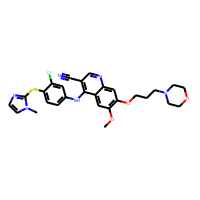
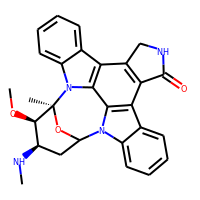
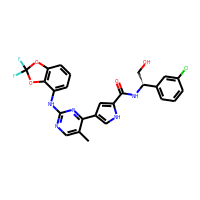
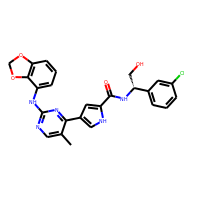
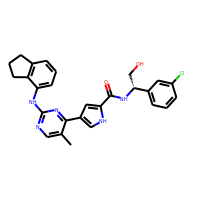

In [19]:
HTML(df.head().to_html())

Cluster the molecules in the dataframe and assign the cluster id to a new column. 

In [20]:
%time df['Cluster'] = butina_cluster(df.ROMol.values)

CPU times: user 4.38 s, sys: 244 ms, total: 4.62 s
Wall time: 4.62 s


,SMILES,Name,is_active,ROMol,Cluster
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,1,,3918
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,1,,3917
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,1,,2
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,1,,2
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4CCC5,575047,1,,2

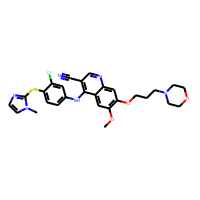
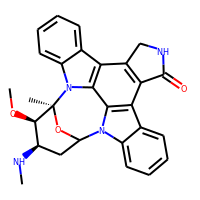
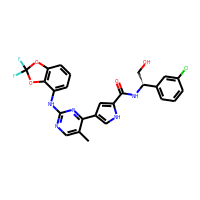
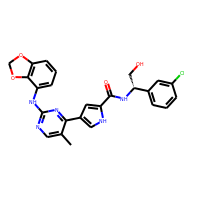
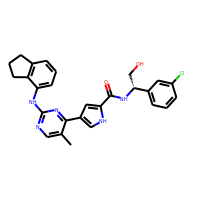

In [21]:
HTML(df.head().to_html())

Let's look at how we could select the molecule from each cluster with the lowest LogP.  First we'll calculate the LogP for each molecule and put these values into into a new column called "logP".

In [22]:
df["logP"] = [Descriptors.MolLogP(mol) for mol in df.ROMol]

,SMILES,Name,is_active,ROMol,Cluster,logP
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCCN5CCOCC5)OC,168691,1,,3918,5.49788
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)NC)OC,86358,1,,3917,4.35400
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OC(O5)(F)F,575087,1,,2,4.96202
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4OCO5,575065,1,,2,4.36922
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3)Cl)Nc4cccc5c4CCC5,575047,1,,2,5.12922

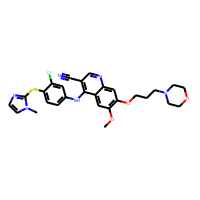
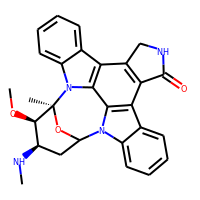
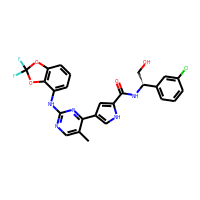
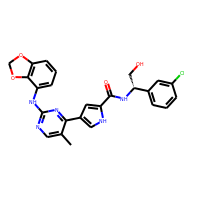
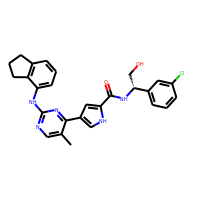

In [23]:
HTML(df.head().to_html())

In [24]:
df.sort_values(["Cluster","logP"],inplace=True)

,SMILES,Name,is_active,ROMol,Cluster,logP
1142,C=CCNS(=O)(=O)c1ccc2c(c1)[C@@H]3C=CC[C@H]3[C@H](N2)c4ccc(cc4O)O,C20681887,0,,1,3.3886
1193,C=CCNS(=O)(=O)c1ccc2c(c1)[C@H]3C=CC[C@H]3[C@H](N2)c4ccc(cc4O)O,C20681890,0,,1,3.3886
387,CC(C)NS(=O)(=O)c1ccc2c(c1)[C@@H]3C=CC[C@@H]3[C@@H](N2)c4ccc(cc4O)O,C13639961,0,,1,3.6110
1137,CC(C)NS(=O)(=O)c1ccc2c(c1)[C@H]3C=CC[C@@H]3[C@@H](N2)c4ccc(cc4O)O,C13639963,0,,1,3.6110
991,CC(C)(C)NS(=O)(=O)c1ccc2c(c1)[C@H]3C=CC[C@@H]3[C@@H](N2)c4ccc(cc4O)O,C13639902,0,,1,4.0011

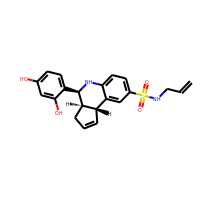
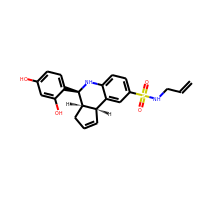
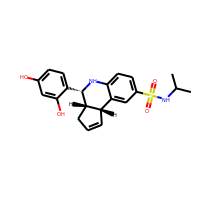
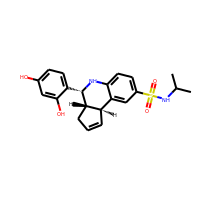
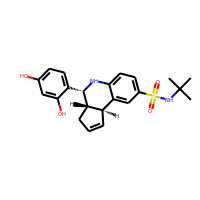

In [25]:
HTML(df.head().to_html())

Now let's create a new dataframe containing only the molecule from each cluster with the lowest LogP.  Since we have already sorted the dataframe by cluster id and LogP, we can simply use the [drop_duplicates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to drop all but the first row in each cluster. 

In [26]:
df_unique = df.drop_duplicates("Cluster")

,SMILES,Name,is_active,ROMol,Cluster,logP
1142,C=CCNS(=O)(=O)c1ccc2c(c1)[C@@H]3C=CC[C@H]3[C@H](N2)c4ccc(cc4O)O,C20681887,0,,1,3.3886
1193,C=CCNS(=O)(=O)c1ccc2c(c1)[C@H]3C=CC[C@H]3[C@H](N2)c4ccc(cc4O)O,C20681890,0,,1,3.3886
387,CC(C)NS(=O)(=O)c1ccc2c(c1)[C@@H]3C=CC[C@@H]3[C@@H](N2)c4ccc(cc4O)O,C13639961,0,,1,3.6110
1137,CC(C)NS(=O)(=O)c1ccc2c(c1)[C@H]3C=CC[C@@H]3[C@@H](N2)c4ccc(cc4O)O,C13639963,0,,1,3.6110
991,CC(C)(C)NS(=O)(=O)c1ccc2c(c1)[C@H]3C=CC[C@@H]3[C@@H](N2)c4ccc(cc4O)O,C13639902,0,,1,4.0011

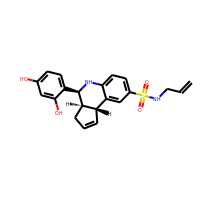
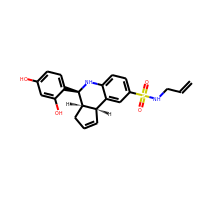
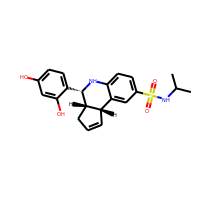
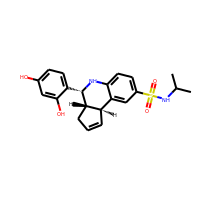
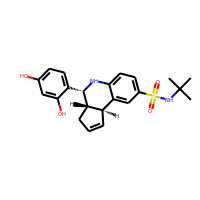

In [27]:
HTML(df.head().to_html())